In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms
import torchaudio.functional
import torch.optim as optim
import torch
import os
from torch.utils.data import Dataset, DataLoader, random_split
from collections import OrderedDict
import psutil  # For monitoring memory usage
from torch.nn.functional import cosine_similarity
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from tqdm import tqdm
from torchsummary import summary
from skimage.transform import resize

sys.path.append('SVEVAE')
from unet.unet_1 import UNet
print("Switched back to:", os.getcwd())

Switched back to: C:\Users\James Lee\Desktop\Course\MachineLearningMusic\project


In [2]:
# Ensure device is set
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def parse_wav_files(base_dir):
    """
    Parse all .wav files and organize them into a dictionary.

    Args:
        base_dir (str): The base directory containing singers' folders.

    Returns:
        dict: A dictionary with keys as "{song_name + technique}" and values as "{singer, technique, file_path (list)}".
    """
    singers_data = {
        "ZH-Alto-1": "Singer_Alto",
        "ZH-Tenor-1": "Singer_Tenor"
    }

    wav_dict = {}

    for singer_folder, singer_name in singers_data.items():
        singer_path = os.path.join(base_dir, "Chinese", singer_folder)

        # Traverse through techniques
        for technique in os.listdir(singer_path):
            technique_path = os.path.join(singer_path, technique)

            if not os.path.isdir(technique_path):
                continue

            # Traverse through song names
            for song_name in os.listdir(technique_path):
                song_path = os.path.join(technique_path, song_name)

                if not os.path.isdir(song_path):
                    continue

                # Traverse through groups
                for group in os.listdir(song_path):
                    group_path = os.path.join(song_path, group)

                    if not os.path.isdir(group_path):
                        continue

                    # Traverse .wav files in the group
                    for file_name in os.listdir(group_path):
                        if file_name.endswith(".wav"):
                            file_path = os.path.join(group_path, file_name)
                            key = f"{song_name}_{technique}"
                            
                            # Add to dictionary
                            if key not in wav_dict:
                                wav_dict[key] = {
                                    "singer": singer_name,
                                    "technique": technique,
                                    "file_path": []
                                }
                            
                            # Append file path to the list
                            wav_dict[key]["file_path"].append(file_path)

    return wav_dict

#################
base_directory = "."  # Replace with the actual path
wav_dict = parse_wav_files(base_directory)

# Remove file paths with "Paired_Speech_Group"
for key, value in wav_dict.items():
    value['file_path'] = [
        path for path in value['file_path']
        if "Paired_Speech_Group" not in path
    ]

# Display the results
for key, value in wav_dict.items():
    print(f"Key: {key}")
    print(f"Value: {value}")
#################

Key: 不再见_Breathy
Value: {'singer': 'Singer_Alto', 'technique': 'Breathy', 'file_path': ['.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0001.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0003.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0004.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0005.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0007.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0009.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0010.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0011.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Control_Group\\0001.wav', '.\\Chinese\\ZH-

.\Chinese\ZH-Alto-1\Breathy\不再见\Breathy_Group\0000.wav


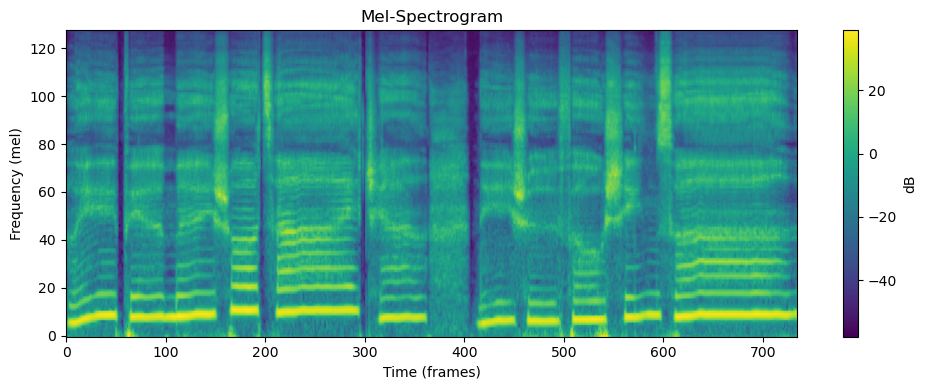

tensor([[[-10.4086,  -4.4013,  -0.5874,  ...,  -2.9934,   1.5708,  -6.3099],
         [ -9.0585, -13.4623,  -9.5855,  ...,  -6.6864,  -3.6872,  -3.9984],
         [-11.6238,  -8.5148,  -8.9959,  ..., -14.7076,  -6.4047,  -7.0163],
         ...,
         [-53.7570, -51.7539, -51.0632,  ..., -41.7295, -41.0629, -44.5898],
         [-50.3043, -51.7813, -51.4161,  ..., -46.1357, -45.2794, -46.0775],
         [-51.2896, -51.0043, -48.6604,  ..., -43.7556, -45.2870, -42.9778]]])


In [4]:
def compute_mel_spectrogram(
    audio_path,
    sample_rate=48000,
    n_fft=2048,
    hop_length=512,
    n_mels=128,
    f_min = 40,
    f_max = 16000,
    to_db=True,
    show_plot=False
):
    """
    Compute the mel-spectrogram of an audio file.
    
    Parameters:
        audio_path (str): Path to the audio file.
        sample_rate (int): Desired sample rate of the audio.
        n_fft (int): Number of FFT points.
        hop_length (int): Number of samples between successive frames.
        n_mels (int): Number of mel filter banks.
        to_db (bool): Whether to convert the spectrogram to decibel scale.
    
    Returns:
        torch.Tensor: Mel-spectrogram (in dB if to_db is True).
    """
    # Load audio file
    waveform, orig_sample_rate = torchaudio.load(audio_path)
    
    # Resample if necessary
    if orig_sample_rate != sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=orig_sample_rate, new_freq=sample_rate)
        waveform = resampler(waveform)
    
    # Create MelSpectrogram transform
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        f_min=35
    )
    
    # Compute the mel-spectrogram
    mel_spec = mel_spectrogram(waveform)
    
    # Convert to dB if required
    if to_db:
        db_transform = torchaudio.transforms.AmplitudeToDB(stype='power')
        mel_spec = db_transform(mel_spec)
        
    # Visualize the mel-spectrogram
    if show_plot:
        plt.figure(figsize=(10, 4))
        plt.imshow(mel_spec[0].numpy(), aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label='dB')
        plt.title('Mel-Spectrogram')
        plt.xlabel('Time (frames)')
        plt.ylabel('Frequency (mel)')
        plt.tight_layout()
        plt.show()
    
    return mel_spec

temp_filepath = wav_dict['不再见_Breathy']['file_path'][0]
print(temp_filepath)
mel_spec = compute_mel_spectrogram(temp_filepath, show_plot=True, n_mels=128)
print(mel_spec)

In [5]:
def compute_global_min_max(data_dict, sample_rate=48000):
    
    global_min = float('inf')
    global_max = float('-inf')
    
    counter = 0

    for key, value in data_dict.items():
        file_paths = value["file_path"]

        for file_path in file_paths:
            
            if counter % 250 == 0:
                print(counter)
            
            # Compute mel-spectrogram for each file
            mel_spectrogram = compute_mel_spectrogram(file_path, sample_rate=sample_rate)

            # Update global min and max
            file_min = mel_spectrogram.min().item()
            file_max = mel_spectrogram.max().item()

            global_min = min(global_min, file_min)
            global_max = max(global_max, file_max)

            # Debugging/logging
            counter = counter + 1
            # print(f"[DEBUG] File: {file_path}, Min: {file_min}, Max: {file_max}")

    return global_min, global_max

# Compute global min and max
# global_mel_min, global_mel_max = compute_global_min_max(wav_dict)
# Min: -100.0, Max: 53.63450622558594
global_mel_min = -100.0
global_mel_max = 54
print(f"Global Mel-Spectrogram Min: {global_mel_min}, Max: {global_mel_max}")

Global Mel-Spectrogram Min: -100.0, Max: 54


In [6]:
# total 4080

class VocalTechniqueDataset(Dataset):
    def __init__(self, data_dict, sample_rate=48000, fixed_timesteps=196, step_size=10, 
                 global_mel_min=-100, global_mel_max=54, transform=None, num_duplicates=5):
        
        """
        Initializes the dataset.

        Args:
            data_dict (dict): Dictionary containing file paths for all techniques.
            sample_rate (int): Sample rate for loading audio.
            fixed_timesteps (int): Fixed number of timesteps for all samples.
            step_size (int): Step size for sequential sampling.
            transform (callable, optional): Transformation to apply to audio.
        """
        
        print("Initializing VocalTechniqueDataset")
        
        self.data_pairs = []
        self.sample_rate = sample_rate
        self.fixed_timesteps = fixed_timesteps
        self.step_size = step_size
        self.transform = transform
        self.global_mel_min = global_mel_min
        self.global_mel_max = global_mel_max

        # techniques list
        techniques = ["Breathy", "Glissando", "Mixed_Voice_and_Falsetto", "Pharyngeal", "Vibrato"]

        for key, value in data_dict.items():
            # Extract control and technique files
            control_files = [path for path in value["file_path"] if "Control_Group" in path]
            technique_files = [path for path in value["file_path"] if "Group" in path and "Control_Group" not in path]

            control_files_map = {os.path.basename(f): f for f in control_files}

            for technique_path in technique_files:
                filename = os.path.basename(technique_path)
                if filename in control_files_map:
                    control_path = control_files_map[filename]

                    # Extract the technique folder name of the target
                    target_technique_folder = os.path.basename(os.path.dirname(technique_path))  # e.g., Falsetto_Group

                    # Find references from other songs but the same technique
                    available_references = []
                    for other_key, other_value in data_dict.items():
                        if other_key != key:  # Ensure different songs
                            other_technique_files = [
                                path for path in other_value["file_path"]
                                if target_technique_folder in path  # Match exact technique folder
                            ]
                            available_references.extend(other_technique_files)

                    # Ensure enough references exist
                    if len(available_references) < num_duplicates:
                        raise ValueError(f"Not enough references for {technique_path} with technique {target_technique_folder}.")

                    # Select references
                    selected_references = random.sample(available_references, num_duplicates)
                    for reference_path in selected_references:
                        pair = (control_path, reference_path, technique_path)
                        self.data_pairs.append(pair)

                        # Debug print for clarity
                        print(f"Added pair: {pair}")
                        
            
    def __len__(self):
        return len(self.data_pairs)

    def sample_fixed_window(self, control_mel, reference_mel, technique_mel, target_timesteps = 256):
        """
        Randomly selects a window of 400 timesteps from all three mel-spectrograms.

        Args:
            control_mel (torch.Tensor): Mel-spectrogram of shape [n_mels, timesteps].
            reference_mel (torch.Tensor): Mel-spectrogram of shape [n_mels, timesteps].
            technique_mel (torch.Tensor): Mel-spectrogram of shape [n_mels, timesteps].

        Returns:
            torch.Tensor: Adjusted control mel-spectrogram of shape [n_mels, 400].
            torch.Tensor: Adjusted reference mel-spectrogram of shape [n_mels, 400].
            torch.Tensor: Adjusted technique mel-spectrogram of shape [n_mels, 400].
        """
        _, control_timesteps = control_mel.shape
        _, reference_timesteps = reference_mel.shape
        _, technique_timesteps = technique_mel.shape

        # Ensure all mel-spectrograms have enough timesteps
        min_timesteps = min(control_timesteps, reference_timesteps, technique_timesteps)
        if min_timesteps < target_timesteps:
            raise ValueError("All mel-spectrograms must have at least 400 timesteps.")

        # Randomly select a starting index for the window
        start_idx = random.randint(0, min_timesteps - target_timesteps)
        end_idx = start_idx + target_timesteps

        # Slice the window from each mel-spectrogram
        control_mel_window = control_mel[:, start_idx:end_idx]
        reference_mel_window = reference_mel[:, start_idx:end_idx]
        technique_mel_window = technique_mel[:, start_idx:end_idx]

        return control_mel_window, reference_mel_window, technique_mel_window
    
    def pitch_match(self, control_waveform, reference_waveform, target_waveform, sample_rate=48000):
        
        
        """
        Align the pitch of reference and target waveforms to match the control waveform.

        Args:
            control_waveform (torch.Tensor): Control waveform tensor [1, time].
            reference_waveform (torch.Tensor): Reference waveform tensor [1, time].
            target_waveform (torch.Tensor): Target waveform tensor [1, time].
            sample_rate (int): Sampling rate of the audio.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Pitch-aligned reference and target waveforms.
        """
        
        print("in pitch_match")
        
        # Ensure mono audio for simplicity
        def to_mono(waveform):
            if waveform.dim() > 1 and waveform.shape[0] > 1:
                return torch.mean(waveform, dim=0, keepdim=True)
            return waveform

        control_waveform = to_mono(control_waveform)
        reference_waveform = to_mono(reference_waveform)
        target_waveform = to_mono(target_waveform)

        # Detect fundamental frequency (F0) for each waveform
        def detect_f0(waveform, sample_rate):
            pitch = torchaudio.functional.detect_pitch_frequency(waveform, sample_rate, frame_time=0.032)
            valid_pitch = pitch[pitch > 0]  # Ignore unvoiced frames
            if len(valid_pitch) > 0:
                return torch.median(valid_pitch).item()  # Median pitch
            else:
                return 0  # No pitch detected

        control_f0 = detect_f0(control_waveform, sample_rate)
        reference_f0 = detect_f0(reference_waveform, sample_rate)
        target_f0 = detect_f0(target_waveform, sample_rate)

        print(f"Control Pitch (F0): {control_f0:.2f} Hz")
        print(f"Reference Pitch (F0): {reference_f0:.2f} Hz")
        print(f"Target Pitch (F0): {target_f0:.2f} Hz")

        # Helper function to pitch shift waveform
        def pitch_shift_to_f0(waveform, source_f0, target_f0, sample_rate):
            if source_f0 > 0 and target_f0 > 0:
                pitch_shift_semitones = 12 * torch.log2(torch.tensor(target_f0 / source_f0)).item()
                print(f"Pitch Shift: {pitch_shift_semitones:.2f} semitones")
                return torchaudio.functional.pitch_shift(waveform, sample_rate=sample_rate, n_steps=pitch_shift_semitones)
            else:
                print("Pitch could not be detected. Returning original waveform.")
                return waveform

        # Align reference and target waveforms to control's pitch
        aligned_reference_waveform = pitch_shift_to_f0(reference_waveform, reference_f0, control_f0, sample_rate)
        aligned_target_waveform = pitch_shift_to_f0(target_waveform, target_f0, control_f0, sample_rate)

        return control_waveform, aligned_reference_waveform, aligned_target_waveform
    
    def pitch_shift(self, control_waveform, reference_waveform, target_waveform, sample_rate=48000):
        """
        Apply the same pitch shift to control, reference, and target waveforms.

        Args:
            control_waveform (torch.Tensor): Control waveform tensor.
            reference_waveform (torch.Tensor): Reference waveform tensor.
            target_waveform (torch.Tensor): Target waveform tensor.
            sample_rate (int): Sampling rate for the audio.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Pitch-shifted control, reference, and target waveforms.
        """
        # Decide the pitch shift in semitones
        if random.random() < 0.5:
            n_steps = random.randint(-6, -1)
        else:
            n_steps = random.randint(1, 6)

        print(f"Applying same pitch shift: {n_steps} semitones")

        # Create the pitch shifter
        pitch_shifter = torchaudio.transforms.PitchShift(sample_rate=sample_rate, n_steps=n_steps)

        # Apply pitch shift to all waveforms
        control_waveform = pitch_shifter(control_waveform)
        reference_waveform = pitch_shifter(reference_waveform)
        target_waveform = pitch_shifter(target_waveform)

        return control_waveform, reference_waveform, target_waveform

    def time_stretch_with_pitch_correction(self, control_waveform, reference_waveform, target_waveform, sample_rate=48000):
        
        """
        Apply the same time stretch and pitch correction to control and target waveforms.

        Args:
            control_waveform (torch.Tensor): Control waveform tensor.
            target_waveform (torch.Tensor): Target waveform tensor.
            sample_rate (int): Sampling rate for the audio.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Time-stretched and pitch-corrected control and target waveforms.
        """
        
        # Decide the time stretch rate
        if random.random() < 0.5:
            rate = random.choice([0.7, 0.75, 0.8, 0.85, 0.9])
        else:
            rate = random.choice([1.1, 1.15, 1.2, 1.25, 1.3])

        print(f"Applying same time stretch with pitch correction: {rate} faster/slower")

        # Function to apply time stretch and pitch correction
        def stretch_and_correct(waveform, rate, sample_rate):
            waveform_np = waveform.squeeze().numpy()
            original_length = len(waveform_np)
            new_length = int(original_length / rate)
            stretched_waveform_np = resize(waveform_np, (new_length,), preserve_range=True)

            stretched_waveform = torch.tensor(stretched_waveform_np, dtype=torch.float32).unsqueeze(0)
            semitones = -12 * torch.log2(torch.tensor(rate))
            pitch_shift_transform = torchaudio.transforms.PitchShift(sample_rate=sample_rate, n_steps=semitones.item())

            return pitch_shift_transform(stretched_waveform)

        # Apply to both control and target waveforms
        control_waveform = stretch_and_correct(control_waveform, rate, sample_rate)
        target_waveform = stretch_and_correct(target_waveform, rate, sample_rate)

        return control_waveform, reference_waveform, target_waveform

    def add_noise(self, control_waveform, reference_waveform, target_waveform, sample_rate=48000):
        """
        Apply Gaussian noise to control and reference waveforms, leaving the target waveform unmodified.

        Args:
            control_waveform (torch.Tensor): Control waveform tensor.
            reference_waveform (torch.Tensor): Reference waveform tensor.
            target_waveform (torch.Tensor): Target waveform tensor.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Control and reference waveforms with noise added,
                                                             target waveform unmodified.
        """
        noise_level = 0.01

        # Apply noise to control waveform
        control_noise = torch.randn_like(control_waveform) * noise_level * control_waveform.abs().max()
        control_waveform = control_waveform + control_noise
        print(f"Added Gaussian noise to control with level {noise_level}")

        # Apply noise to reference waveform
        reference_noise = torch.randn_like(reference_waveform) * noise_level * reference_waveform.abs().max()
        reference_waveform = reference_waveform + reference_noise
        print(f"Added Gaussian noise to reference with level {noise_level}")

        # Target waveform remains unmodified
        return control_waveform, reference_waveform, target_waveform

    def time_mask(self, control_waveform, reference_waveform, target_waveform, sample_rate=48000):
        """
        Apply random time masks independently to control, reference, and target waveforms.

        Args:
            control_waveform (torch.Tensor): Control waveform tensor.
            reference_waveform (torch.Tensor): Reference waveform tensor.
            target_waveform (torch.Tensor): Target waveform tensor.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Control, reference, and target waveforms with time masks applied.
        """
        def mask_waveform(waveform):
            n_mels, time_steps = waveform.shape
            num_masks = random.randint(5, 15)

            for _ in range(num_masks):
                mask_width = random.choice(range(5, 20))
                mask_start = random.randint(0, time_steps - mask_width)
                print(f"Masking waveform: from {mask_start} to {mask_start + mask_width}")
                waveform[:, mask_start:mask_start + mask_width] = -100.0

            return waveform

        # Independently mask each waveform
        control_waveform = mask_waveform(control_waveform)
        reference_waveform = mask_waveform(reference_waveform)
        target_waveform = mask_waveform(target_waveform)

        return control_waveform, reference_waveform, target_waveform

    def frequency_filter(self, control_waveform, reference_waveform, target_waveform, sample_rate=48000):
        """
        Apply a frequency filter to control and reference waveforms, leaving the target waveform unmodified.

        Args:
            control_waveform (torch.Tensor): Control waveform tensor.
            reference_waveform (torch.Tensor): Reference waveform tensor.
            target_waveform (torch.Tensor): Target waveform tensor.
            sample_rate (int): Sampling rate for the audio.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Control and reference waveforms with frequency filtering applied,
                                                             target waveform unmodified.
        """
        low_freq = 200
        high_freq = 2000
        central_freq = (low_freq + high_freq) / 2
        Q = 1.0

        # Apply frequency filter to control waveform
        print("Applying frequency filter to control waveform")
        control_waveform = torchaudio.functional.bandpass_biquad(control_waveform, sample_rate, central_freq, Q)

        # Apply frequency filter to reference waveform
        print("Applying frequency filter to reference waveform")
        reference_waveform = torchaudio.functional.bandpass_biquad(reference_waveform, sample_rate, central_freq, Q)

        # Target waveform remains unmodified
        return control_waveform, reference_waveform, target_waveform
    
    # not use
    """
    def transform_to_mel_and_mask_bins(self, waveform, sample_rate, n_mels=256, augment_prob=0.5, 
                                       f_min=72, f_max=None, hop_length=512, n_fft=2048):
        if waveform.ndim == 1:
            waveform = waveform.unsqueeze(0)  # Add batch dimension

        mel_transform = T.MelSpectrogram(
            sample_rate=sample_rate, 
            n_mels=n_mels,
            f_min=f_min,
            f_max=f_max,
            hop_length=hop_length, 
            n_fft=n_fft
        )
        mel_spectrogram = mel_transform(waveform).squeeze(0)  # Remove batch dimension
        print(f"Mel-spectrogram shape: {mel_spectrogram.shape}")

        if augment_prob < 0.5:
            print("Applying augmentation: masking random mel bins")
            num_bins_to_mask = random.randint(10, 20)
            for _ in range(num_bins_to_mask):
                mel_bin = random.randint(0, n_mels - 1)
                mel_spectrogram[mel_bin, :] = 0.0
        else:
            print("No augmentation applied")

        return mel_spectrogram
    """
    
    
    def augment_data(self, control_waveform, reference_waveform, target_waveform, sample_rate=48000):
        
        """
        Apply random augmentation to the control, reference, and target audio.

        Args:
            control_path (str): Path to the control audio.
            reference_path (str): Path to the reference audio.
            target_path (str): Path to the target audio.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Augmented control, reference, and target waveforms.
        """
        
        print("in augment_data")
        
        if random.random() < 0.5:
            print(f"Applying augmentation: time_stretch")
            control_waveform, reference_waveform, target_waveform = \
                self.time_stretch_with_pitch_correction(control_waveform, reference_waveform, target_waveform, sample_rate=48000)

        
        if random.random() < 0.5:
            print(f"Applying augmentation: pitch_shift")
            control_waveform, reference_waveform, target_waveform = \
                self.pitch_shift(control_waveform, reference_waveform, target_waveform, sample_rate=48000)
            
        if random.random() < 0.5:
            print(f"Applying augmentation: frequency_filter")
            control_waveform, reference_waveform, target_waveform = \
                self.frequency_filter(control_waveform, reference_waveform, target_waveform, sample_rate=48000)
            
        if random.random() < 0.5:
            print(f"Applying augmentation: time_mask")
            control_waveform, reference_waveform, target_waveform = \
                self.time_mask(control_waveform, reference_waveform, target_waveform, sample_rate=48000)
            
        if random.random() < 0.5:
            print(f"Applying augmentation: add_noise")
            control_waveform, reference_waveform, target_waveform = \
                self.add_noise(control_waveform, reference_waveform, target_waveform, sample_rate=48000)
            
        """
        if random.random() < 0.5:
            print(f"Applying augmentation: transform_to_mel_and_mask_bins to {name}")
            waveform = transform_to_mel_and_mask_bins(waveform, self.sample_rate)
        """
            

        return control_waveform, reference_waveform, target_waveform
    
    def compute_mel_spectrogram(
        self,
        waveform,
        sample_rate=44100,
        n_fft=2048,
        hop_length=512,
        n_mels=128,
        f_min = 40,
        f_max = 16000,
        to_db=True,
        show_plot=False
    ):
        """
        Compute the mel-spectrogram of a waveform tensor.

        Parameters:
            waveform (torch.Tensor): Input waveform tensor of shape [channels, samples].
            sample_rate (int): Desired sample rate of the audio.
            n_fft (int): Number of FFT points.
            hop_length (int): Number of samples between successive frames.
            n_mels (int): Number of mel filter banks.
            to_db (bool): Whether to convert the spectrogram to decibel scale.
            show_plot (bool): Whether to display the mel-spectrogram plot.

        Returns:
            torch.Tensor: Mel-spectrogram (in dB if to_db is True).
        """
        # Ensure waveform is in correct shape: [channels, samples]
        if waveform.dim() == 1:
            waveform = waveform.unsqueeze(0)  # Add channel dimension if missing

        # Create MelSpectrogram transform
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            f_min=35
        )

        # Compute the mel-spectrogram
        mel_spec = mel_spectrogram(waveform)

        # Convert to dB if required
        if to_db:
            db_transform = torchaudio.transforms.AmplitudeToDB(stype='power')
            mel_spec = db_transform(mel_spec)

        # Visualize the mel-spectrogram
        if show_plot:
            plt.figure(figsize=(10, 4))
            plt.imshow(mel_spec[0].numpy(), aspect='auto', origin='lower', cmap='viridis')
            plt.colorbar(label='dB')
            plt.title('Mel-Spectrogram')
            plt.xlabel('Time (frames)')
            plt.ylabel('Frequency (mel)')
            plt.tight_layout()
            plt.show()

        return mel_spec
    
    def normalize_mel(self, mel):
        """
        Normalize the mel-spectrogram to range [0, 1].
        Args:
            mel (np.ndarray or torch.Tensor): Input mel-spectrogram.
        Returns:
            torch.Tensor: Normalized mel-spectrogram.
        """
        return (mel - self.global_mel_min) / (self.global_mel_max - self.global_mel_min + 1e-8)
    
    
    def __getitem__(self, idx):
        
        control_path, reference_path, technique_path = self.data_pairs[idx]
        # print(f"control_path: {control_path}")
        # print(f"reference_path: {reference_path}")
        # print(f"target_path: {target_path}")
        
        # Define the target sample rate
        target_sample_rate = 48000

        # Load waveforms
        control_waveform, orig_sample_rate = torchaudio.load(control_path)
        # Resample the waveform
        resampler = torchaudio.transforms.Resample(orig_freq=orig_sample_rate, new_freq=target_sample_rate)
        control_waveform = resampler(control_waveform)
        
        reference_waveform, orig_sample_rate = torchaudio.load(reference_path)
        # Resample the waveform
        resampler = torchaudio.transforms.Resample(orig_freq=orig_sample_rate, new_freq=target_sample_rate)
        reference_waveform = resampler(reference_waveform)
        
        technique_waveform, orig_sample_rate = torchaudio.load(technique_path)
        # Resample the waveform
        resampler = torchaudio.transforms.Resample(orig_freq=orig_sample_rate, new_freq=target_sample_rate)
        technique_waveform = resampler(technique_waveform)
        
        # match pitch
        # control_waveform, reference_waveform, target_waveform = self.pitch_match(control_waveform, reference_waveform, target_waveform)
        
        # data augmentation
        # control_waveform, reference_waveform, target_waveform = self.augment_data(control_waveform, reference_waveform, target_waveform)
        
        # Load audio
        control_mel = self.compute_mel_spectrogram(control_waveform, sample_rate=self.sample_rate)
        reference_mel = self.compute_mel_spectrogram(reference_waveform, sample_rate=self.sample_rate)
        technique_mel = self.compute_mel_spectrogram(technique_waveform, sample_rate=self.sample_rate)
        
        # print("--------------- before shape operations 1 ---------------")
        # print(f"control_mel.shape: {control_mel.shape}")
        # print(f"reference_mel.shape: {reference_mel.shape}")
        # print(f"technique_mel.shape: {technique_mel.shape}")
        
        # print("--------------- after shape operations 1 ---------------")
        # Remove the extra batch dimension if present
        control_mel = control_mel.squeeze(0)  # Shape becomes [n_mels, timesteps]
        reference_mel = reference_mel.squeeze(0)
        technique_mel = technique_mel.squeeze(0)  # Shape becomes [n_mels, timesteps]
        # print(f"control_mel.shape: {control_mel.shape}")
        # print(f"reference_mel.shape: {reference_mel.shape}")
        # print(f"technique_mel.shape: {technique_mel.shape}")
        
        # Normalize mel-spectrograms
        control_mel = self.normalize_mel(control_mel)
        reference_mel = self.normalize_mel(reference_mel)
        technique_mel = self.normalize_mel(technique_mel)
        
        # print("--------------- before shape operations 2 ---------------")
        # print(f"control_mel.shape: {control_mel.shape}")
        # print(f"reference_mel.shape: {reference_mel.shape}")
        # print(f"technique_mel.shape: {technique_mel.shape}")
        
        # get windowed mel.
        control_mel, reference_mel, technique_mel = self.sample_fixed_window(control_mel, reference_mel, technique_mel)
        
        # Ensure correct shape: [1, 256, 400] → Add batch and channel dimension
        control_mel = control_mel.unsqueeze(0)  # Shape: [1, 256, fixed_timesteps] → [1, 256, 400]
        reference_mel = reference_mel.unsqueeze(0)
        technique_mel = technique_mel.unsqueeze(0)
        # print("--------------- after shape operations 2 ---------------")
        # print(f"control_mel.shape: {control_mel.shape}")
        # print(f"reference_mel.shape: {reference_mel.shape}")
        # rint(f"technique_mel.shape: {technique_mel.shape}")
        
        

        return {
            "control_mel": control_mel,
            "reference_mel": reference_mel,
            "technique_mel": technique_mel,
            "control_path": control_path,
            "reference_path": reference_path,
            "technique_path": technique_path
            # "control_waveform": control_waveform
            # "reference_waveform": reference_waveform
            # "technique_waveform": technique_waveform
        }
    
    
    def get_data(self):
        return self.data_pairs
    
    def validate_pairs(self):
        """
        Validate all pairs in self.data_pairs:
            1. Control and target have the same song and clip name (ignoring parent folder).
            2. Reference and target have the same technique.

        Returns:
            bool: True if all pairs are valid, otherwise raises an error.
        """
        for idx, (control_path, reference_path, target_path) in enumerate(self.data_pairs):
            # Extract song names and clip names
            control_song = os.path.basename(os.path.dirname(os.path.dirname(control_path)))  # e.g., "不再见"
            target_song = os.path.basename(os.path.dirname(os.path.dirname(target_path)))    # e.g., "不再见"

            control_clip = os.path.basename(control_path)  # e.g., "0000.wav"
            target_clip = os.path.basename(target_path)    # e.g., "0000.wav"

            # Check 1: Control and target are from the same song and same clip
            if control_song != target_song or control_clip != target_clip:
                raise ValueError(
                    f"Control and target mismatch at index {idx}:\n"
                    f"Control: {control_path}\nTarget: {target_path}"
                )

            # Check 2: Reference and target have the same technique
            # Technique is assumed to be encoded in the parent folder (e.g., "Breathy_Group" or "Mixed_Voice_Group")
            reference_technique = os.path.basename(os.path.dirname(reference_path))  # e.g., "Breathy_Group"
            target_technique = os.path.basename(os.path.dirname(target_path))        # e.g., "Breathy_Group"

            if reference_technique != target_technique:
                raise ValueError(
                    f"Reference and target technique mismatch at index {idx}:\n"
                    f"Reference: {reference_path} ({reference_technique})\n"
                    f"Target: {target_path} ({target_technique})"
                )
                
            print(f"control: {control_song}/{control_clip}, target: {target_song}/{target_clip}")
            print(f"reference_technique: {reference_technique}, target_technique:{target_technique}")

        print("All pairs are valid: Control and target match, reference and target share the same technique.")
        return True
    
# create dataset
dataset = VocalTechniqueDataset(wav_dict, global_mel_min=global_mel_min, global_mel_max=global_mel_max)
dataset.validate_pairs()

Initializing VocalTechniqueDataset
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\默\\Breathy_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\说谎\\Breathy_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Breathy\\爱的回归线\\Breathy_Group\\0004.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Breathy\\我真的受伤了\\Breathy_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Breathy_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\不再见\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\水星记\\Breathy_Group\\0002.wav', 

Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\云烟成雨\\Control_Group\\0009.wav', '.\\Chinese\\ZH-Tenor-1\\Breathy\\不染\\Breathy_Group\\0007.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\云烟成雨\\Breathy_Group\\0009.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\云烟成雨\\Control_Group\\0009.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\慢慢喜欢你\\Breathy_Group\\0007.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\云烟成雨\\Breathy_Group\\0009.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\云烟成雨\\Control_Group\\0009.wav', '.\\Chinese\\ZH-Tenor-1\\Breathy\\平凡的一天\\Breathy_Group\\0007.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\云烟成雨\\Breathy_Group\\0009.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\云烟成雨\\Control_Group\\0009.wav', '.\\Chinese\\ZH-Tenor-1\\Breathy\\化身孤岛的鲸\\Breathy_Group\\0012.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\云烟成雨\\Breathy_Group\\0009.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\云烟成雨\\Control_Group\\0009.wav', '.\\Chinese\\ZH-Tenor-1\\Breathy\\会呼吸的痛\\Breathy_Group\\0016.wav', '.\\Chinese\\ZH-Al

Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\失落沙洲\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Tenor-1\\Breathy\\给电影人的情书\\Breathy_Group\\0004.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\失落沙洲\\Breathy_Group\\0002.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\失落沙洲\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\温柔\\Breathy_Group\\0012.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\失落沙洲\\Breathy_Group\\0002.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\失落沙洲\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\给电影人的情书\\Breathy_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\失落沙洲\\Breathy_Group\\0002.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\失落沙洲\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\成都\\Breathy_Group\\0004.wav', '.\\Chinese\\ZH-Alto-1\\Breathy\\失落沙洲\\Breathy_Group\\0002.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Breathy\\失落沙洲\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Tenor-1\\Breathy\\如果爱忘了\\Breathy_Group\\0011.wav', '.\\Chinese\\ZH-Alto

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Glissando\\传奇\\Control_Group\\0005.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\给电影人的情书\\Glissando_Group\\0010.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\传奇\\Glissando_Group\\0005.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Glissando\\传奇\\Control_Group\\0005.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\青花瓷\\Glissando_Group\\0003.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\传奇\\Glissando_Group\\0005.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Glissando\\传奇\\Control_Group\\0005.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\光阴的故事\\Glissando_Group\\0007.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\传奇\\Glissando_Group\\0005.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Glissando\\传奇\\Control_Group\\0005.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\如果爱忘了\\Glissando_Group\\0012.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\传奇\\Glissando_Group\\0005.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Glissando\\传奇\\Control_Group\\0005.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\十年\\Glissando_Group

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Glissando\\传奇\\Control_Group\\0018.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\时间煮雨\\Glissando_Group\\0015.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\传奇\\Glissando_Group\\0018.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Glissando\\传奇\\Control_Group\\0018.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\时间都去哪儿了\\Glissando_Group\\0005.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\传奇\\Glissando_Group\\0018.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Glissando\\传奇\\Control_Group\\0018.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\我只在乎你\\Glissando_Group\\0006.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\传奇\\Glissando_Group\\0018.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Glissando\\传奇\\Control_Group\\0018.wav', '.\\Chinese\\ZH-Alto-1\\Glissando\\岁月神偷\\Glissando_Group\\0001.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\传奇\\Glissando_Group\\0018.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Glissando\\传奇\\Control_Group\\0018.wav', '.\\Chinese\\ZH-Tenor-1\\Glissando\\给电影人的情书\\Glissan

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\倒带\\Mixed_Voice_Group\\0016.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Mixed_Voice_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\别找我麻烦\\Mixed_Voice_Group\\0008.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Mixed_Voice_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走着走着就散了\\Mixed_Voice_Group\\0008.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Mixed_Voice_Group\\0000.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\一次就好\\Control_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\我喜欢上你时的内心活动\\Mixed_Voice_Group\\0011.wav', 

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\三寸天堂\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\红玫瑰\\Falsetto_Group\\0014.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\三寸天堂\\Falsetto_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\三寸天堂\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\终于等到你\\Falsetto_Group\\0007.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\三寸天堂\\Falsetto_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\三寸天堂\\Control_Group\\0006.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\情歌\\Falsetto_Group\\0017.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\三寸天堂\\Falsetto_Group\\0006.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\三寸天堂\\Control_Group\\0007.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\桃花诺\\Falsetto_Group\\0003.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_F

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Control_Group\\0019.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\情歌\\Mixed_Voice_Group\\0017.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Mixed_Voice_Group\\0019.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Control_Group\\0019.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\终于等到你\\Mixed_Voice_Group\\0007.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Mixed_Voice_Group\\0019.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Control_Group\\0019.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\菊花台\\Mixed_Voice_Group\\0006.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Mixed_Voice_Group\\0019.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可惜没如果\\Control_Group\\0019.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\时间煮雨\\Mixed_Voice_Group\\0001.wav', '.\\Chinese\

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\平凡之路\\Control_Group\\0001.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\倒带\\Falsetto_Group\\0008.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\平凡之路\\Falsetto_Group\\0001.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\平凡之路\\Control_Group\\0001.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\你就不要想起我\\Falsetto_Group\\0002.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\平凡之路\\Falsetto_Group\\0001.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\平凡之路\\Control_Group\\0001.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\情歌\\Falsetto_Group\\0022.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\平凡之路\\Falsetto_Group\\0001.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\平凡之路\\Control_Group\\0001.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\我的歌声里\\Falsetto_Group\\0017.wav', '.\\Chinese\\ZH-Tenor-1\\Mixe

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\时间煮雨\\Control_Group\\0004.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\我的歌声里\\Mixed_Voice_Group\\0007.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\时间煮雨\\Mixed_Voice_Group\\0004.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\时间煮雨\\Control_Group\\0004.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\走着走着就散了\\Mixed_Voice_Group\\0011.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\时间煮雨\\Mixed_Voice_Group\\0004.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\时间煮雨\\Control_Group\\0004.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\可乐\\Mixed_Voice_Group\\0004.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\时间煮雨\\Mixed_Voice_Group\\0004.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\时间煮雨\\Control_Group\\0004.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\修炼爱情\\Mixed_Voice_Group\\0000.wav', '.\\Chinese\\

Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\演员\\Control_Group\\0009.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\烟花易冷\\Mixed_Voice_Group\\0020.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\演员\\Mixed_Voice_Group\\0009.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\演员\\Control_Group\\0009.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\爱情转移\\Mixed_Voice_Group\\0012.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\演员\\Mixed_Voice_Group\\0009.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\演员\\Control_Group\\0009.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\我的歌声里\\Mixed_Voice_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\演员\\Mixed_Voice_Group\\0009.wav')
Added pair: ('.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\演员\\Control_Group\\0009.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\菊花台\\Mixed_Voice_Group\\0021.wav', '.\\Chinese\\ZH-Alto-1\\Mi

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\白月光与朱砂痣\\Control_Group\\0005.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\青花瓷\\Falsetto_Group\\0020.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\白月光与朱砂痣\\Falsetto_Group\\0005.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\白月光与朱砂痣\\Control_Group\\0005.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\剑伤\\Falsetto_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\白月光与朱砂痣\\Falsetto_Group\\0005.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\白月光与朱砂痣\\Control_Group\\0005.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\爱情转移\\Falsetto_Group\\0011.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\白月光与朱砂痣\\Falsetto_Group\\0005.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\白月光与朱砂痣\\Control_Group\\0005.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\枫\\Falsetto_Group\\0001.wav', '.\\Chinese\\ZH-Alto-1

Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\给电影人的情书\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\终于等到你\\Falsetto_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\给电影人的情书\\Falsetto_Group\\0002.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\给电影人的情书\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\最初的梦想\\Falsetto_Group\\0008.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\给电影人的情书\\Falsetto_Group\\0002.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\给电影人的情书\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\一次就好\\Falsetto_Group\\0000.wav', '.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\给电影人的情书\\Falsetto_Group\\0002.wav')
Added pair: ('.\\Chinese\\ZH-Alto-1\\Mixed_Voice_and_Falsetto\\给电影人的情书\\Control_Group\\0002.wav', '.\\Chinese\\ZH-Tenor-1\\Mixed_Voice_and_Falsetto\\倒带\\Falsetto_Group\\0015.wav', '.\\Chinese\\ZH-

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



True

In [7]:
# Define split sizes (e.g., 80% train, 10% validation, 10% test)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate lengths of each split
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # Ensures all data is used

# Perform random split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Wrap datasets into DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print dataset sizes
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

counter = 0
for batch in train_loader:
    
    if counter == 10:
        break
    
    control = batch["control_mel"]
    reference = batch["reference_mel"]
    technique = batch["technique_mel"]
    
    print(f"control type: {type(control)}, shape: {control.shape}")
    print(f"reference type: {type(reference)}, shape: {reference.shape}")
    print(f"technique type: {type(technique)}, shape: {technique.shape}")
    
    counter = counter + 1

Train size: 16320, Validation size: 2040, Test size: 2040
control type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 128, 256])
reference type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 128, 256])
technique type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 128, 256])
control type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 128, 256])
reference type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 128, 256])
technique type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 128, 256])
control type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 128, 256])
reference type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 128, 256])
technique type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 128, 256])
control type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 128, 256])
reference type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 128, 256])
technique type: <class 'torch.Tensor'>, shape: torch.Size([16, 1, 128, 256])
control type: <class 'torc

In [8]:
class LogSpectralLoss(nn.Module):
    def __init__(self, eps=1e-8, reduction='mean'):
        super(LogSpectralLoss, self).__init__()
        self.eps = eps  # Small constant to avoid log(0)
        self.reduction = reduction  # Reduction method ('mean' or 'sum')

    def forward(self, pred, target):
        # Apply logarithmic scaling
        log_pred = torch.log(pred + self.eps)
        log_target = torch.log(target + self.eps)
        
        # Compute L1 loss on the log-scaled spectrograms
        loss = torch.abs(log_pred - log_target)
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss  # No reduction

In [9]:
class ExponentialLoss(nn.Module):
    def __init__(self, alpha=1.0, reduction='mean'):
        super(ExponentialLoss, self).__init__()
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, pred, target):
        # Calculate the exponential weights
        weights = torch.exp(-self.alpha * target)
        
        # Compute the weighted absolute difference
        loss = weights * torch.abs(target - pred)
        
        # Apply reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss  # No reduction

In [14]:
class SobelEdgeLoss(nn.Module):
    def __init__(self):
        super(SobelEdgeLoss, self).__init__()
        # Define Sobel kernels
        self.sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    def forward(self, pred, target):
        # Move Sobel kernels to the same device as the input
        sobel_x = self.sobel_x.to(pred.device)
        sobel_y = self.sobel_y.to(pred.device)

        # Compute Sobel edges for the predicted output
        pred_edges_x = torch.nn.functional.conv2d(pred, sobel_x, padding=1)
        pred_edges_y = torch.nn.functional.conv2d(pred, sobel_y, padding=1)
        pred_edges = torch.sqrt(pred_edges_x ** 2 + pred_edges_y ** 2)

        # Compute Sobel edges for the target
        target_edges_x = torch.nn.functional.conv2d(target, sobel_x, padding=1)
        target_edges_y = torch.nn.functional.conv2d(target, sobel_y, padding=1)
        target_edges = torch.sqrt(target_edges_x ** 2 + target_edges_y ** 2)

        # Compute the loss between edge maps
        return F.mse_loss(pred_edges, target_edges)

In [ ]:
model = UNet(latent_dim=64).to(device)  # Move to GPU if available
# criterion = nn.MSELoss()
# criterion = LogSpectralLoss()
# criterion = ExponentialLoss(alpha=3, reduction="mean")
criterion = SobelEdgeLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

# List to store average loss per epoch
epoch_losses = []

for epoch in range(num_epochs):
    
    model.train()  # Set the model to training mode
    epoch_loss = 0.0

    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
        
        for batch_idx, batch in enumerate(train_loader):
            # Move data to the appropriate device
            control_mel = batch["control_mel"].to(device)
            reference_mel = batch["reference_mel"].to(device)
            technique_mel = batch["technique_mel"].to(device)

            # Forward pass
            outputs = model(control_mel)

            # Compute the loss
            loss = criterion(outputs, technique_mel)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update epoch loss
            epoch_loss += loss.item()

            # Update progress bar
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)

    # Calculate and store average epoch loss
    avg_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(avg_epoch_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} - Average Loss: {avg_epoch_loss:.6f}")

# Plot the loss after training
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


Epoch 1/10


Training: 100%|████████████████████████████████████████████████████| 1020/1020 [13:50<00:00,  1.23batch/s, loss=0.0334]


Epoch 1/10 - Average Loss: 0.035433

Epoch 2/10


Training: 100%|████████████████████████████████████████████████████| 1020/1020 [13:10<00:00,  1.29batch/s, loss=0.0305]


Epoch 2/10 - Average Loss: 0.032865

Epoch 3/10


Training: 100%|████████████████████████████████████████████████████| 1020/1020 [12:38<00:00,  1.34batch/s, loss=0.0364]


Epoch 3/10 - Average Loss: 0.032643

Epoch 4/10


Training: 100%|████████████████████████████████████████████████████| 1020/1020 [12:27<00:00,  1.37batch/s, loss=0.0325]


Epoch 4/10 - Average Loss: 0.032507

Epoch 5/10


Training: 100%|████████████████████████████████████████████████████| 1020/1020 [12:17<00:00,  1.38batch/s, loss=0.0351]


Epoch 5/10 - Average Loss: 0.032375

Epoch 6/10


Training:  68%|████████████████████████████████████                 | 693/1020 [08:21<04:03,  1.34batch/s, loss=0.0296]

In [ ]:
from torchsummary import summary

summary(model, input_size=(1, 128, 256))

In [ ]:
torch.save(model.state_dict(), "UNet_2_state_dict.pth")

In [ ]:
def denormalize_mel(normalized_mel, global_min, global_max):
    """
    Reverse the normalization of a mel-spectrogram.

    Args:
        normalized_mel (torch.Tensor): Normalized mel-spectrogram tensor.
        global_min (float): Global minimum value used for normalization.
        global_max (float): Global maximum value used for normalization.

    Returns:
        torch.Tensor: Original mel-spectrogram tensor.
    """
    # Reverse normalization
    original_mel = normalized_mel * (global_max - global_min) + global_min
    return original_mel

In [ ]:
model.eval()  # Set the model to evaluation mode

data = train_dataset[0]  # Replace with the desired sample index
control_mel = data["control_mel"].unsqueeze(0).to(device)
technique_mel = data["technique_mel"].unsqueeze(0).to(device)

control_path = data["control_path"]
technique_path = data["technique_path"]

# control_waveform = data["control_waveform"]
# technique_waveform = data["technique_waveform"]


print(control_mel.shape)

model_output = None

# Run inference
with torch.no_grad():  # Disable gradient computation for inference
    
    output = model(control_mel)
    model_output = denormalize_mel(output, global_min=global_mel_min, global_max=global_mel_max)
    
    print(model_output)
    

In [ ]:
def plot_mel_spectrogram_direct(mel_spectrogram, title="Mel-Spectrogram"):
    """
    Plots the mel-spectrogram.
    
    Args:
        mel_spectrogram (torch.Tensor): The mel-spectrogram to plot.
        title (str): Title of the plot.
    """
    # Handle various possible shapes of mel-spectrogram
    if len(mel_spectrogram.shape) == 4:  # Example: [1, 1, 128, 400]
        mel_spectrogram = mel_spectrogram.squeeze(0).squeeze(0)  # Shape becomes [128, 400]
    elif len(mel_spectrogram.shape) == 3:  # Example: [1, 128, 400]
        mel_spectrogram = mel_spectrogram.squeeze(0)  # Shape becomes [128, 400]
    elif len(mel_spectrogram.shape) == 2:  # Example: [128, 400]
        pass  # Already in the correct shape
    else:
        raise ValueError(f"Invalid mel-spectrogram shape: {mel_spectrogram.shape}. Expected [128, 400].")
    
    # Plot the mel-spectrogram
    plt.figure(figsize=(10, 6))
    plt.imshow(mel_spectrogram.cpu().numpy(), aspect='auto', origin='lower', cmap='viridis')
    plt.title(title)
    plt.xlabel("Time (Frames)")
    plt.ylabel("Mel Frequency Bins")
    plt.colorbar(label="Amplitude (dB)")
    plt.tight_layout()
    plt.show()

# Example usage
plot_mel_spectrogram_direct(model_output, title="Model Output Mel-Spectrogram")

In [ ]:
plot_mel_spectrogram_direct(technique_mel, title="Model Output Mel-Spectrogram")

In [ ]:
from nsf_hifigan.models import Generator

from nsf_hifigan.env import AttrDict
import json

# Load hyperparameters from a config file (optional)
with open("nsf_hifigan/config.json", "r") as f:
    hparams = AttrDict(json.load(f))

# Initialize the model
nsf_hifigan_vocoder = Generator(hparams)

state_dict = torch.load("nsf_hifigan/model", map_location="cuda")  # Use "cuda" if you want to load on GPU
# print(state_dict.keys())  # Inspect the keys in the loaded file

nsf_hifigan_vocoder.load_state_dict(state_dict["generator"])  # Replace "generator" with the correct key

In [ ]:
import pyworld as pw

def process_and_generate_audio_with_filepath(
    mel_spec, file_path, model, device, target_sample_rate=48000, output_path="nsf_hifigan_test.wav"
):
    """
    Process a mel-spectrogram and an audio file to extract F0 and synthesize audio using a vocoder model.
    
    Args:
        mel_spec (torch.Tensor): Mel-spectrogram tensor of shape [1, n_mels, time_steps].
        technique_path (str): Path to the input audio file.
        model (torch.nn.Module): The pretrained vocoder model.
        device (torch.device): The device to run the computation on (e.g., "cuda" or "cpu").
        target_sample_rate (int): The target sample rate for resampling. Default is 48000.
        output_path (str): Path to save the generated audio. Default is "nsf_hifigan_test.wav".
    """
    print("Input technique path:", file_path)

    # Step 1: Ensure mel_spec has the correct shape
    if mel_spec.ndim == 4:  # If the shape is [1, 1, n_mels, time_steps]
        mel_spec = mel_spec.squeeze(1)  # Remove the redundant dimension

    print(f"Mel spectrogram shape after squeezing: {mel_spec.shape}")

    # Step 2: Load and resample the waveform
    waveform, orig_sample_rate = torchaudio.load(file_path)
    resampler = torchaudio.transforms.Resample(orig_freq=orig_sample_rate, new_freq=target_sample_rate)
    waveform = resampler(waveform).numpy().astype("float64")
    waveform = waveform.squeeze()  # Ensure waveform is 1D

    # Step 3: Extract F0
    _f0, timeaxis = pw.dio(waveform, target_sample_rate)  # Raw F0 extraction
    f0 = pw.stonemask(waveform, _f0, timeaxis, target_sample_rate)  # Refining F0
    f0_tensor = torch.tensor(f0, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

    # Step 4: Interpolate F0 to match the mel-spectrogram time steps
    f0_tensor = F.interpolate(
        f0_tensor.unsqueeze(1),  # Add channel dimension for interpolation
        size=mel_spec.shape[-1],  # Match the time steps of the mel spectrogram
        mode="linear",
        align_corners=False,
    ).squeeze(1)  # Remove channel dimension

    # Step 5: Generate audio using the vocoder
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        print(f"Mel spectrogram shape: {mel_spec.shape}")
        print(f"F0 tensor shape: {f0_tensor.shape}")
        output = model(mel_spec.to(device), f0_tensor)

    print("Output shape:", output.shape)

    # Step 6: Save the generated waveform
    output_waveform = output.cpu().squeeze(0)  # Remove batch dimension
    print(f"Final output shape for saving: {output_waveform.shape}")
    torchaudio.save(output_path, output_waveform, target_sample_rate)
    print(f"Generated audio saved at: {output_path}")
    
    
# List of denormalized mel-spectrograms (e.g., model outputs)
mel_spectrograms = model_output  # Replace with actual tensors
mel_spectrograms = model_output.squeeze(1)
print(f"mel_spectrograms.shape: {mel_spectrograms.shape}")
print(f"{mel_spectrograms}")

process_and_generate_audio_with_filepath(
    mel_spec=model_output,
    file_path=control_path,
    model=nsf_hifigan_vocoder,
    device=device,
    target_sample_rate=48000,
    output_path="nsf_hifigan_generated_test.wav"
)

In [ ]:
technique_mel.shape

In [ ]:
mel_spectrograms = technique_mel.squeeze(1)
mel_spectrograms = denormalize_mel(mel_spectrograms, global_min=global_mel_min, global_max=global_mel_max)
print(f"technique_mel.shape: {mel_spectrograms.shape}")
print(f"{mel_spectrograms}")

process_and_generate_audio_with_filepath(
    mel_spec=mel_spectrograms,
    file_path=technique_path,
    model=nsf_hifigan_vocoder,
    device=device,
    target_sample_rate=48000,
    output_path="nsf_hifigan_technique_test.wav"
)

In [ ]:
from torchaudio.prototype.pipelines import HIFIGAN_VOCODER_V3_LJSPEECH as bundle

def convert_mel_to_wav(mel_spectrogram, output_path):
    """
    Convert a mel-spectrogram to a .wav file using torchaudio's HiFiGAN vocoder.

    Args:
        mel_spectrogram (torch.Tensor): Input mel-spectrogram with shape [n_mels, timesteps].
        output_path (str): File path to save the generated .wav file.
    """

    # Set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the pre-trained HiFi-GAN vocoder
    vocoder = bundle.get_vocoder().to(device)
    vocoder.eval()

    print(f"mel_spectrogram.shape: {mel_spectrogram.shape}")

    with torch.no_grad():
        # Ensure mel-spectrogram is of the correct shape [batch_size, n_mels, timesteps]
        if len(mel_spectrogram.shape) == 2:
            mel_spectrogram = mel_spectrogram.unsqueeze(0)  # Add batch dimension

        # Move the mel-spectrogram to the same device as the model
        mel_spectrogram = mel_spectrogram.to(device)

        # Ensure the number of mel bins matches the expected value
        if mel_spectrogram.size(1) != bundle._vocoder_params["in_channels"]:
            raise ValueError(f"Expected {bundle._vocoder_params['in_channels']} mel bins, but got {mel_spectrogram.size(1)}.")

        # Pass the mel-spectrogram through the vocoder
        waveform = vocoder(mel_spectrogram)
        print(f"waveform.shape: {waveform.shape}")

        # Reshape waveform for plotting and saving
        waveform = waveform.squeeze().cpu()  # Remove all singleton dimensions
        if waveform.dim() == 1:
            waveform = waveform.unsqueeze(0)  # Add channel dimension for mono audio

        # Plot the waveform
        plt.figure(figsize=(10, 4))
        for i, channel in enumerate(waveform):
            plt.plot(channel.numpy(), label=f"Channel {i + 1}")
        plt.title("Waveform")
        plt.xlabel("Time (samples)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()

        # Save the waveform
        torchaudio.save(output_path, waveform, 48000)

    print(f"Generated audio saved to: {output_path}")


# List of denormalized mel-spectrograms (e.g., model outputs)
mel_spectrograms = model_output  # Replace with actual tensors
mel_spectrograms = model_output.squeeze(1)
print(f"mel_spectrograms.shape: {mel_spectrograms.shape}")
print(f"{mel_spectrograms}")

# Directory to save generated .wav files
output_dir = "./generated_wavs"
os.makedirs(output_dir, exist_ok=True)

# Generate audio files
output_path = os.path.join(output_dir, f"output_generated_2.wav")
convert_mel_to_wav(mel_spectrograms, output_path)

In [ ]:
# List of denormalized mel-spectrograms (e.g., model outputs)
# mel_spectrograms = technique_mel.squeeze(1)
mel_spectrograms = denormalize_mel(technique_mel, global_min=global_mel_min, global_max=global_mel_max).squeeze(1)
print(f"mel_spectrograms.shape: {mel_spectrograms.shape}")
print(f"{mel_spectrograms}")

# Directory to save generated .wav files
output_dir = "./generated_wavs"
os.makedirs(output_dir, exist_ok=True)

# Generate audio files
output_path = os.path.join(output_dir, f"output_technique_2.wav")
convert_mel_to_wav(mel_spectrograms, output_path)

In [ ]:
import pyworld as pw
import numpy as np

print(technique_path)

test_input = compute_mel_spectrogram(technique_path, show_plot=True, n_mels=128)
test_input = test_input.squeeze(1).to(device)

# Load the audio file (technique_path is the file path to the audio)
waveform, orig_sample_rate = torchaudio.load(technique_path)

target_sample_rate = 48000  # Target sample rate

# Resample the waveform
resampler = torchaudio.transforms.Resample(orig_freq=orig_sample_rate, new_freq=target_sample_rate)
waveform = resampler(waveform).numpy().astype("float64")

# Convert waveform to a numpy array and ensure it's 1D
waveform = waveform.squeeze()

_f0, timeaxis = pw.dio(waveform, sample_rate)  # Step 1: Raw F0 extraction
f0 = pw.stonemask(waveform, _f0, timeaxis, sample_rate)  # Step 2: Refining F0

# Convert F0 to a PyTorch tensor
f0_tensor = torch.tensor(f0, dtype=torch.float32)

# Add batch dimension if needed (e.g., [batch_size, timesteps])
f0_tensor = f0_tensor.unsqueeze(0).to(device)  # Shape: [1, timesteps]

f0_tensor = F.interpolate(
    f0_tensor.unsqueeze(1),  # Add a channel dimension for interpolation
    size=600,               # Target size
    mode='linear',          # Linear interpolation
    align_corners=False     # Required for linear interpolation
).squeeze(1)                # Remove the channel dimension

# Assuming `model` is an instance of Generator
nsf_hifigan_vocoder = nsf_hifigan_vocoder.to(device)
nsf_hifigan_vocoder.eval()  # Set model to evaluation mode

# Perform a forward pass
with torch.no_grad():  # No gradients required for inference
    
    print(f"test_input.shape: {test_input.shape}")
    print(f"f0_tensor.shape: {f0_tensor.shape}")
    
    output = nsf_hifigan_vocoder(test_input, f0_tensor)

print("Output shape:", output.shape)  # Check the shape of the generated waveform

# Save the waveform
print(f"shape: {output.cpu().squeeze(0).shape}")
torchaudio.save("nsf_hifigan_test.wav", output.cpu().squeeze(0), 48000)